# Fetch Streets GeoJSON from OpenStreetMap

This notebook will:
1. Load the streets from the first ordinance (protocol 6747)
2. Query OpenStreetMap for each street's geometry
3. Create GeoJSON features for visualization


In [63]:
import json
import requests
import time
from shapely.geometry import shape
from tqdm.notebook import tqdm
import os

# Load ordinances
with open('ordinanze.json') as f:
    ordinanze = json.load(f)

# Get first ordinance streets
first_ordinance = ordinanze['ordinance_6747']
streets = []
for zone, zone_streets in first_ordinance['zones'].items():
    for street in zone_streets:
        streets.append({
            'name': street,
            'zone': zone
        })

print(f"Found {len(streets)} streets to process")


Found 20 streets to process


In [117]:

# rome bb
rome_bb = "41.8002,12.4009,41.9722,12.6095"  # Rome bounding box coordinates

# Cache helpers
import os

def load_cache(cache_name):
    try:
        with open(f'cache/{cache_name}.json', 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        return {}

def save_cache(cache_data, cache_name):
    os.makedirs('cache', exist_ok=True)
    with open(f'cache/{cache_name}.json', 'w') as f:
        json.dump(cache_data, f, indent=2)

# Function to get OSM IDs from Nominatim with caching
def get_osm_ids(street_name, city="Roma"):
    cache = load_cache('nominatim')
    cache_key = f"{street_name}_{city}"
    
    # Check cache first
    if cache_key in cache:
        print(f"Using cached data for {street_name}")
        return cache[cache_key]
    
    print(f"Fetching data for {street_name}")
    user_agent = "zone_rosse_it"
    viewbox = rome_bb
    url = f"https://nominatim.openstreetmap.org/search?q={street_name}&format=json&viewbox={viewbox}&bounded=1&limit=50"
    
    try:
        response = requests.get(url, headers={"User-Agent": user_agent})
        data = response.json()
        
        # Get all results that are ways (streets) in Rome
        street_segments = []
        for result in data:
            if (result['osm_type'] == 'way' and 
                result.get('class') == 'highway' and 
                'Roma' in result['display_name']):
                street_segments.append({
                    'osm_id': result['osm_id'],
                    'display_name': result['display_name']
                })
        
        if street_segments:
            print(f"Found {len(street_segments)} segments for {street_name}")
            cache[cache_key] = street_segments
            save_cache(cache, 'nominatim')
            return street_segments
        
        print(f"No street found for {street_name}")
        cache[cache_key] = None
        save_cache(cache, 'nominatim')
        return None
        
    except Exception as e:
        print(f"Error processing {street_name}: {str(e)}")
        return None

# Process all streets
features= []

def get_street_geometry(osm_id, city_bb):
    overpass_url = "http://overpass-api.de/api/interpreter"
    # First get the name of this street
    query = f"""
    [out:json];
    way({osm_id});
    out tags;
    """
    response_original = requests.post(overpass_url, data=query)
    data_original = response_original.json()
    if data_original:
        # print(f"We got the original data")
        pass
    else:
        print(f"We did not get the original data for {osm_id}")
        return None
    
    street_name = data_original['elements'][0]['tags'].get('name', '')
    
    # print(street_name)

    # Now get all streets with this name within Rome's bounding box
    query = f"""
    [out:json];
    way[name="{street_name}"]({city_bb});
    out geom;
    """

    # print(query)
    response = requests.post(overpass_url, data=query)
    data = response.json()
    if data:
        # print(data)
        pass
    
    return [element['geometry'] for element in data['elements']] 

osm_ids = []
for street in tqdm(streets):
    results = get_osm_ids(street['name'])
    if results:
        for result in results:
            osm_ids.append({
                'osm_id': result['osm_id'],
                'zone': street['zone'],
                'name': street['name']
            })
        print(f"Got {len(results)} osm_ids for {street['name']}")

geometry_list = []
for osm_data in tqdm(osm_ids):
    geometry = get_street_geometry(osm_data['osm_id'], city_bb=rome_bb)
    if geometry:
        for geom in geometry:
            geometry_list.append({
                'geometry': geom,
                'zone': osm_data['zone'],
                'name': osm_data['name']
            })

# save
# Convert geometry list to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for geom_data in geometry_list:
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": [[p['lon'], p['lat']] for p in geom_data['geometry']]
        },
        "properties": {
            "zone": geom_data['zone'],
            "name": geom_data['name']
        }
    }
    geojson['features'].append(feature)

# Save to file
with open('ordinanza_6747_streets.geojson', 'w') as f:
    json.dump(geojson, f)


  0%|          | 0/20 [00:00<?, ?it/s]

Using cached data for Via Giovanni Giolitti
Got 4 osm_ids for Via Giovanni Giolitti
Using cached data for Via Giovanni Amendola
Got 2 osm_ids for Via Giovanni Amendola
Using cached data for Via Filippo Turati
Got 2 osm_ids for Via Filippo Turati
Using cached data for Via Principe Amedeo
Got 3 osm_ids for Via Principe Amedeo
Using cached data for Via Daniele Manin
Got 2 osm_ids for Via Daniele Manin
Using cached data for Via Vincenzo Gioberti
Using cached data for Piazza Manfredo Fanti
Got 2 osm_ids for Piazza Manfredo Fanti
Using cached data for Via Carlo Cattaneo
Got 1 osm_ids for Via Carlo Cattaneo
Using cached data for Via Enrico Cialdini
Got 1 osm_ids for Via Enrico Cialdini
Using cached data for Via Urbano Rattazzi
Got 2 osm_ids for Via Urbano Rattazzi
Using cached data for Via Alfredo Cappellini
Got 1 osm_ids for Via Alfredo Cappellini
Using cached data for Via Mamiani
Got 1 osm_ids for Via Mamiani
Using cached data for Via Bettino Ricasoli
Using cached data for Via La Marmora
Go

  0%|          | 0/31 [00:00<?, ?it/s]

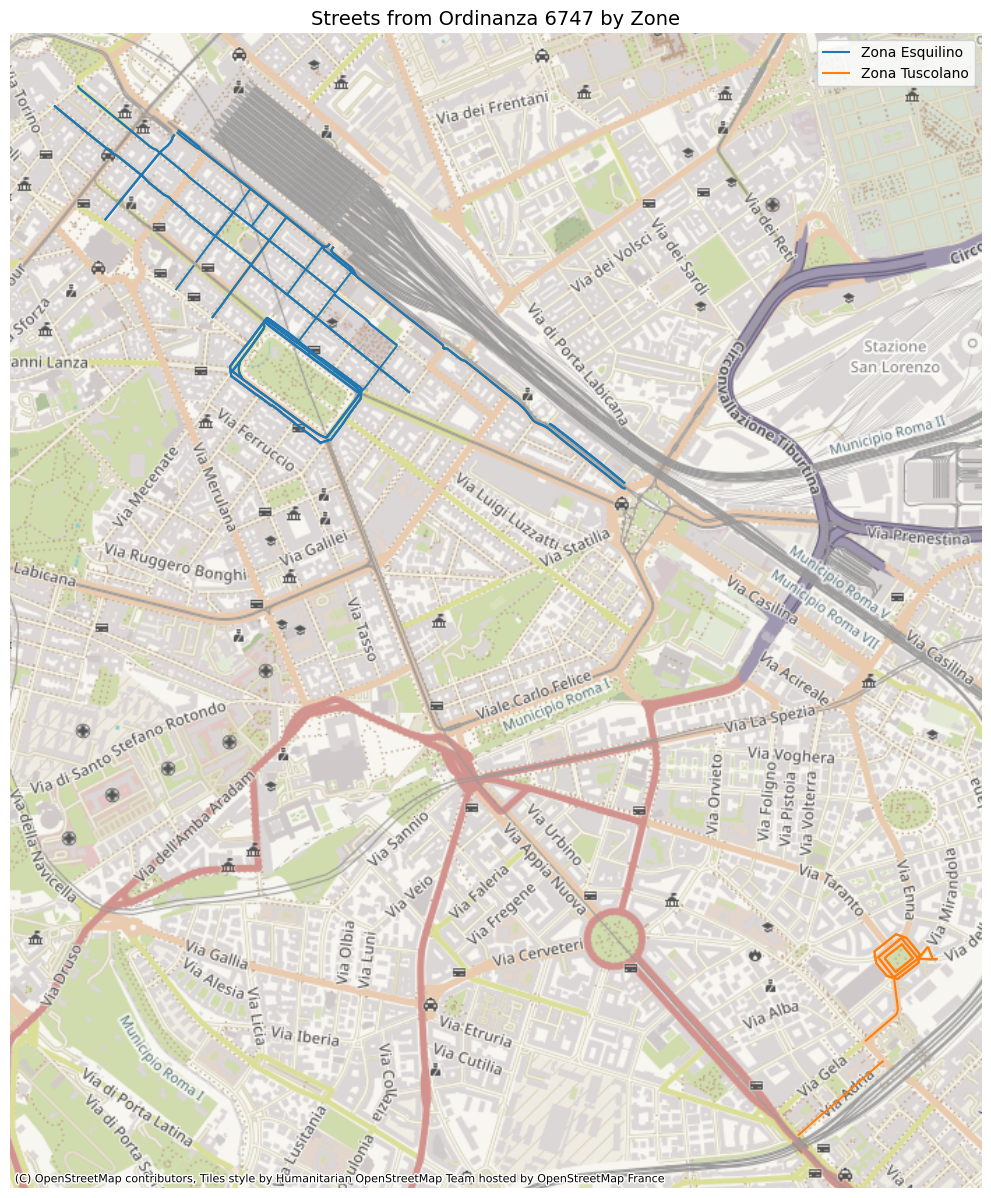

In [121]:
# Plot the streets using GeoPandas
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Read the GeoJSON file
streets_gdf = gpd.read_file('ordinanza_6747_streets.geojson')

# Convert to Web Mercator projection for contextily
streets_gdf = streets_gdf.to_crs(epsg=3857)

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Plot streets by zone with different colors
for i, zone in enumerate(streets_gdf['zone'].unique()):
    zone_streets = streets_gdf[streets_gdf['zone'] == zone]
    zone_streets.plot(ax=ax, label=zone, color=plt.cm.tab10(i))

# Add OpenStreetMap tiles as background
ctx.add_basemap(ax)

# Add title and legend
plt.title('Streets from Ordinanza 6747 by Zone', fontsize=14)
plt.legend(fontsize=10)

# Remove axis labels since this is a map
ax.set_axis_off()

# Show the plot
plt.show()


In [122]:
# Create an interactive map with Folium
import folium
import json

# Create a map centered on Rome
m = folium.Map(location=[41.9028, 12.4964], zoom_start=14)

# Load GeoJSON data
with open('ordinanza_6747_streets.geojson') as f:
    streets_data = json.load(f)

# Define colors for each zone
zone_colors = {
    'Zona Esquilino': 'red',
    'Zona Tuscolano': 'blue'
}

# Add GeoJSON layers with different colors per zone
for zone in zone_colors:
    # Filter features for this zone
    zone_features = {
        "type": "FeatureCollection",
        "features": [f for f in streets_data['features'] if f['properties']['zone'] == zone]
    }
    
    # Add the layer with custom style
    folium.GeoJson(
        zone_features,
        name=zone,
        style_function=lambda x, color=zone_colors[zone]: {
            'color': color,
            'weight': 3,
            'fillOpacity': 0.7
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['name', 'zone'],
            aliases=['Street:', 'Zone:'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m
